# IDEA: We may NOT need much datapoints for training a QCNN

In [2]:
""" This module implements the base function to implement a VQE for a Ising Chain with Transverse Field. """
from pennylane import numpy as np

import sys
sys.path.insert(0, '../')
import vqe as vqe
import annni_model as annni
import qcnn as qcnn
import visualization as qplt
import losses
import general as qmlgen
import encoder as enc

from matplotlib import pyplot as plt

In [68]:
# Load all possible VQEs to compute the transition phase line
N    = 6
side = 100

In [69]:
path = '../data/vqes/ANNNI/'
filename = 'N'+str(N)+'n'+str(side)

In [70]:
lr = .2
epochs = 1000

train_index_line  = np.arange(0,2*side-1)
lines = np.concatenate((np.arange(side), np.arange(1,side)*side))


In [71]:
vqeclass = vqe.load_vqe(path + filename)

In [72]:
qcnnclass = qcnn.qcnn(vqeclass, qcnn.qcnn_circuit, n_outputs = 2)


In [73]:
qcnnclass.train(lr, epochs, train_index_line, losses.cross_entropy, circuit = True)


+--- CIRCUIT ---+
0: ──||──||──RY(0.00)──||──RY(6.00)─────||──RY(9.00)──╭C──RY(13.00)──||─╭C─────────────────────────
1: ──||──||──RY(1.00)──||──RY(6.00)─╭C──||──RY(10.00)─╰X──RY(14.00)──||─╰ControlledOperation(19.00)
2: ──||──||──RY(2.00)──||──RY(7.00)─╰X──||──RY(10.00)─╭C──RY(15.00)──||─╭C─────────────────────────
3: ──||──||──RY(3.00)──||──RY(7.00)─╭C──||──RY(11.00)─╰X──RY(16.00)──||─╰ControlledOperation(21.00)
4: ──||──||──RY(4.00)──||──RY(8.00)─╰X──||──RY(11.00)─╭C──RY(17.00)──||─╭C─────────────────────────
5: ──||──||──RY(5.00)──||──RY(8.00)─────||──RY(12.00)─╰X──RY(18.00)──||─╰ControlledOperation(23.00)

──╭C───────────────────────────||──||────────────────||───────────────────────────────────||
──╰ControlledOperation(20.00)──||──||──RY(25.00)─────||──RY(27.00)─╭C──────────RY(29.00)──||
──╭C───────────────────────────||──||────────────────||────────────│──────────────────────||
──╰ControlledOperation(22.00)──||──||──RY(25.00)─╭C──||──RY(28.00)─╰X──────────RY(30.00)──||
──╭C─────

Cost: 0.09643571078777313: 100%|██████████| 1000/1000 [00:15<00:00, 64.21it/s] 


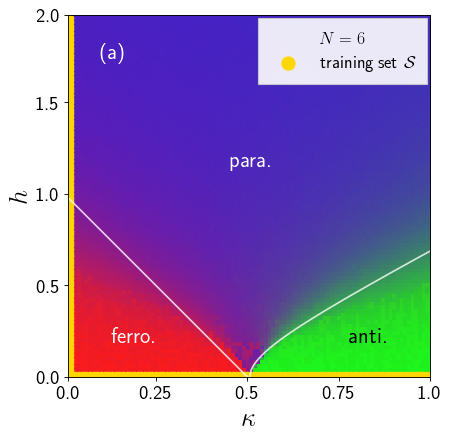

In [74]:
qplt.show_QCNN_classificationANNNI(qcnnclass, hard_thr = False, train_index = lines, label = 'a', info=True)


In [158]:
import pennylane as qml
import jax

def ANNNI_accuracy(qcnnclass, plot = False):
    circuit = qcnnclass.vqe_qcnn_circuit
    side = int(np.sqrt(qcnnclass.n_states))
    
    @qml.qnode(qcnnclass.device, interface="jax")
    def qcnn_circuit_prob(params_vqe, params):
        circuit(params_vqe, params)
    
        return [qml.probs(wires=int(k)) for k in qcnnclass.final_active_wires]
    
    vcircuit = jax.vmap(lambda v: qcnn_circuit_prob(v, qcnnclass.params), in_axes=(0))

    predictions = np.array(np.argmax(vcircuit(qcnnclass.vqe_params), axis = 2))

    labels       = []
    for idx in range(side*side):
        # compute coordinates and normalize for x in [0,1]
        # and y in [0,2]
        x = (idx//side)/side
        y = 2*(idx%side)/side
        
        if x <= .5:
            if (1 - 2*x <= y):
                labels.append([1,1])
            else:
                labels.append([0,1])
        else:
            if (1.05 * np.sqrt((x-.5)*(x-.1))) <= y:
                labels.append([1,1])
            else:
                labels.append([1,0])

    correct = (np.sum(np.array(labels) == predictions, axis = 1).astype(int) == 2)
    accuracy = np.sum(correct)/(side*side)

    if plot:
        qplt.show_QCNN_classificationANNNI(qcnnclass, hard_thr = True)
        plt.show()
        plt.imshow(np.rot90(np.reshape(correct, (100,100))), cmap = 'RdYlGn')
        plt.show()
        
    return accuracy

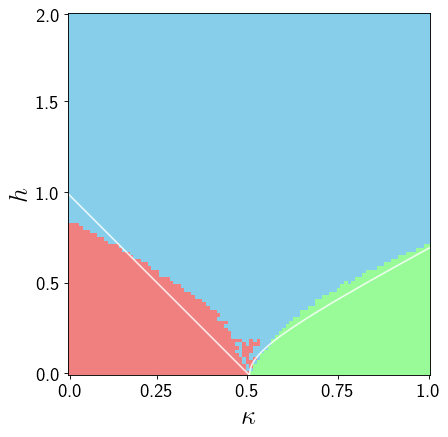

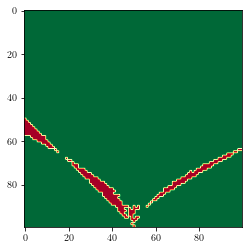

tensor(0.9683, requires_grad=True)

In [160]:
ANNNI_accuracy(qcnnclass, plot = True)

In [161]:
# Load all possible VQEs to compute the transition phase line
N    = 12
side = 100

path = '../data/vqes/ANNNI/'
filename = 'N'+str(N)+'n'+str(side)
